## Linear Discriminant Analysis (LDA) is most commonly used as dimensionality reduction technique in the pre-processing step for pattern-classification and machine learning applications. The goal is to project a dataset onto a lower-dimensional space with good class-separability in order avoid overfitting (“curse of dimensionality”) and also reduce computational costs.

# Summarizing the LDA approach in 5 steps
## Listed below are the 5 general steps for performing a linear discriminant analysis; we will explore them in more detail in the following sections.

1. Compute the d-dimensional mean vectors for the different classes from the dataset.
2. Compute the scatter matrices (in-between-class and within-class scatter matrix).
3. Compute the eigenvectors (ee1,ee2,...,eed) and corresponding eigenvalues (λλ1,λλ2,...,λλd) for the scatter matrices.
4. Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix WW (where every column represents an eigenvector).
5. Use this d×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the matrix multiplication: YY=XX×WW (where XX is a n×d-dimensional matrix representing the n samples, and yy are the transformed n×k-dimensional samples in the new subspace).

In [1]:
feature_dict = {i:label for i,label in zip(
                range(4),
                  ('sepal length in cm',
                  'sepal width in cm',
                  'petal length in cm',
                  'petal width in cm', ))}

In [2]:
import pandas as pd

df = pd.io.parsers.read_csv(
    filepath_or_buffer='https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    header=None,
    sep=',',
    )
df.columns = [l for i,l in sorted(feature_dict.items())] + ['class label']
df.dropna(how="all", inplace=True) # to drop the empty line at file-end

df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class label
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


In [3]:
from sklearn.preprocessing import LabelEncoder

X = df[[0,1,2,3]].values
y = df['class label'].values

enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y) + 1

label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}

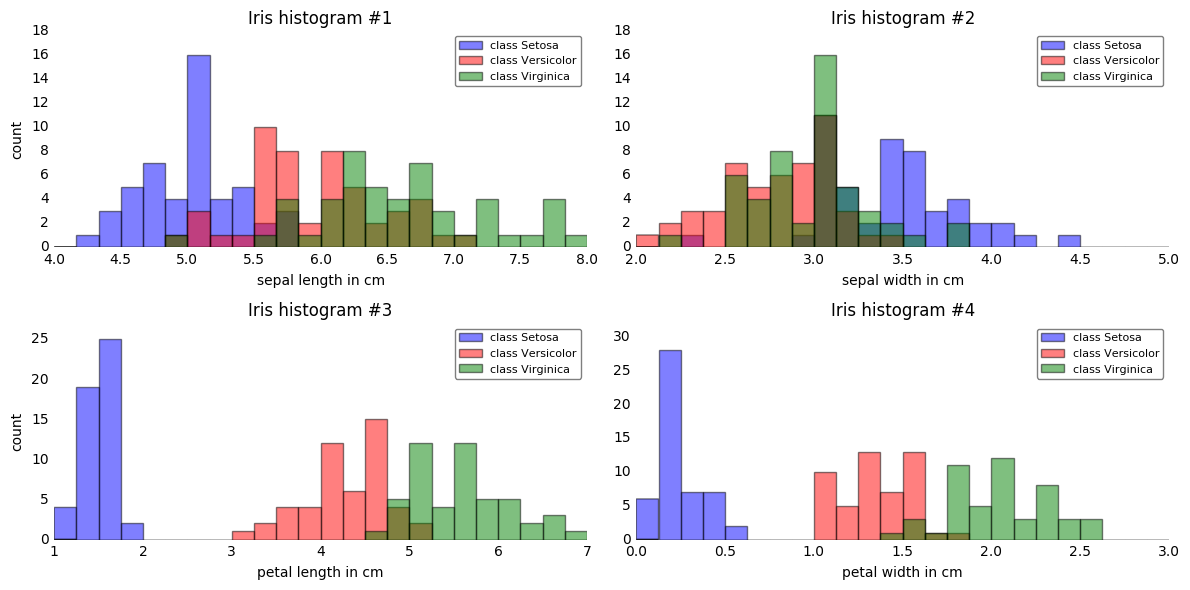

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import math

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6))

for ax,cnt in zip(axes.ravel(), range(4)):  

    # set bin sizes
    min_b = math.floor(np.min(X[:,cnt]))
    max_b = math.ceil(np.max(X[:,cnt]))
    bins = np.linspace(min_b, max_b, 25)

    # plottling the histograms
    for lab,col in zip(range(1,4), ('blue', 'red', 'green')):
        ax.hist(X[y==lab, cnt],
                   color=col,
                   label='class %s' %label_dict[lab],
                   bins=bins,
                   alpha=0.5,)
    ylims = ax.get_ylim()

    # plot annotation
    leg = ax.legend(loc='upper right', fancybox=True, fontsize=8)
    leg.get_frame().set_alpha(0.5)
    ax.set_ylim([0, max(ylims)+2])
    ax.set_xlabel(feature_dict[cnt])
    ax.set_title('Iris histogram #%s' %str(cnt+1))

    # hide axis ticks
    ax.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

axes[0][0].set_ylabel('count')
axes[1][0].set_ylabel('count')

fig.tight_layout()       

plt.show()

## Step 1: Computing the d-dimensional mean vectors
In this first step, we will start off with a simple computation of the mean vectors mmi, (i=1,2,3) of the 3 different flower classes:

In [5]:
np.set_printoptions(precision=4)

mean_vectors = []
for cl in range(1,4):
    mean_vectors.append(np.mean(X[y==cl], axis=0))
    print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))

Mean Vector class 1: [5.006 3.418 1.464 0.244]

Mean Vector class 2: [5.936 2.77  4.26  1.326]

Mean Vector class 3: [6.588 2.974 5.552 2.026]



## Step 2: Computing the Scatter Matrices
Now, we will compute the two 4x4-dimensional matrices: The within-class and the between-class scatter matrix.

### 2.1 Within-class scatter matrix SW
The within-class scatter matrix SW is computed by the following equation:

SW=∑i=1cSi
where
Si=∑xx∈Din(xx−mmi)(xx−mmi)T
(scatter matrix for every class)

and mmi is the mean vector 
mmi=1ni∑xx∈Dinxxk

In [6]:
S_W = np.zeros((4,4))
for cl,mv in zip(range(1,4), mean_vectors):
    class_sc_mat = np.zeros((4,4))                  # scatter matrix for every class
    for row in X[y == cl]:
        row, mv = row.reshape(4,1), mv.reshape(4,1) # make column vectors
        class_sc_mat += (row-mv).dot((row-mv).T)
    S_W += class_sc_mat                             # sum class scatter matrices
print('within-class Scatter Matrix:\n', S_W)

within-class Scatter Matrix:
 [[38.9562 13.683  24.614   5.6556]
 [13.683  17.035   8.12    4.9132]
 [24.614   8.12   27.22    6.2536]
 [ 5.6556  4.9132  6.2536  6.1756]]


### 2.1 b
Alternatively, we could also compute the class-covariance matrices by adding the scaling factor 1N−1 to the within-class scatter matrix, so that our equation becomes

Σi=1Ni−1∑xx∈Din(xx−mmi)(xx−mmi)T.

and SW=∑i=1c(Ni−1)Σi
where Ni is the sample size of the respective class (here: 50), and in this particular case, we can drop the term (Ni−1) since all classes have the same sample size.

However, the resulting eigenspaces will be identical (identical eigenvectors, only the eigenvalues are scaled differently by a constant factor).

### 2.2 Between-class scatter matrix SB
The between-class scatter matrix SB is computed by the following equation:

SB=∑i=1cNi(mmi−mm)(mmi−mm)T
where
mm is the overall mean, and mmi and Ni are the sample mean and sizes of the respective classes.

In [7]:
overall_mean = np.mean(X, axis=0)

S_B = np.zeros((4,4))
for i,mean_vec in enumerate(mean_vectors):  
    n = X[y==i+1,:].shape[0]
    mean_vec = mean_vec.reshape(4,1) # make column vector
    overall_mean = overall_mean.reshape(4,1) # make column vector
    S_B += n * (mean_vec - overall_mean).dot((mean_vec - overall_mean).T)

print('between-class Scatter Matrix:\n', S_B)

between-class Scatter Matrix:
 [[ 63.2121 -19.534  165.1647  71.3631]
 [-19.534   10.9776 -56.0552 -22.4924]
 [165.1647 -56.0552 436.6437 186.9081]
 [ 71.3631 -22.4924 186.9081  80.6041]]


## Step 3: Solving the generalized eigenvalue problem for the matrix S−1WSB
Next, we will solve the generalized eigenvalue problem for the matrix S−1WSB to obtain the linear discriminants.

In [8]:
eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))

for i in range(len(eig_vals)):
    eigvec_sc = eig_vecs[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eig_vals[i].real))


Eigenvector 1: 
[[-0.2049]
 [-0.3871]
 [ 0.5465]
 [ 0.7138]]
Eigenvalue 1: 3.23e+01

Eigenvector 2: 
[[ 0.009 ]
 [ 0.589 ]
 [-0.2543]
 [ 0.767 ]]
Eigenvalue 2: 2.78e-01

Eigenvector 3: 
[[ 0.138 ]
 [-0.326 ]
 [-0.3796]
 [ 0.6671]]
Eigenvalue 3: -2.17e-16

Eigenvector 4: 
[[ 0.138 ]
 [-0.326 ]
 [-0.3796]
 [ 0.6671]]
Eigenvalue 4: -2.17e-16


## Checking the eigenvector-eigenvalue calculation
## A quick check that the eigenvector-eigenvalue calculation is correct and satisfy the equation:

Av=λv
where
A=S−1WSB
v=Eigenvector
λ=Eigenvalue

In [9]:
for i in range(len(eig_vals)):
    eigv = eig_vecs[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(S_W).dot(S_B).dot(eigv),
                                         eig_vals[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)

## Step 4: Selecting linear discriminants for the new feature subspace
4.1. Sorting the eigenvectors by decreasing eigenvalues
Remember from the introduction that we are not only interested in merely projecting the data into a subspace that improves the class separability, but also reduces the dimensionality of our feature space, (where the eigenvectors will form the axes of this new feature subspace).

However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1.

So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace, we have to take a look at the corresponding eigenvalues of the eigenvectors. Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop.
The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top k eigenvectors.

In [10]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n') # last 2 should be exactly 0
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

32.271957799729854
0.27756686384004725
4.0593327525858315e-15
4.0593327525858315e-15


Note

If we take a look at the eigenvalues, we can already see that 2 eigenvalues are close to 0. The reason why these are close to 0 is not that they are not informative but it’s due to floating-point imprecision. In fact, these two last eigenvalues should be exactly zero: In LDA, the number of linear discriminants is at most c−1 where c is the number of class labels, since the in-between scatter matrix SB is the sum of c matrices with rank 1 or less. Note that in the rare case of perfect collinearity (all aligned sample points fall on a straight line), the covariance matrix would have rank one, which would result in only one eigenvector with a nonzero eigenvalue.

Now, let’s express the “explained variance” as percentage:

In [11]:
print('Variance explained:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.15%
eigenvalue 2: 0.85%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


## 4.2. Choosing k eigenvectors with the largest eigenvalues
After sorting the eigenpairs by decreasing eigenvalues, it is now time to construct our k×d-dimensional eigenvector matrix WW (here 4×2: based on the 2 most informative eigenpairs) and thereby reducing the initial 4-dimensional feature space into a 2-dimensional feature subspace.

In [12]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.2049  0.009 ]
 [-0.3871  0.589 ]
 [ 0.5465 -0.2543]
 [ 0.7138  0.767 ]]


## Step 5: Transforming the samples onto the new subspace
In the last step, we use the 4×2-dimensional matrix WW that we just computed to transform our samples onto the new subspace via the equation

Y=X×W.

(where X is a n×d-dimensional matrix representing the n samples, and YY are the transformed n×k-dimensional samples in the new subspace).

In [14]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2), "The matrix is not 150x2 dimensional."

In [15]:
W.shape

(4, 2)

In [16]:
X.shape

(150, 4)

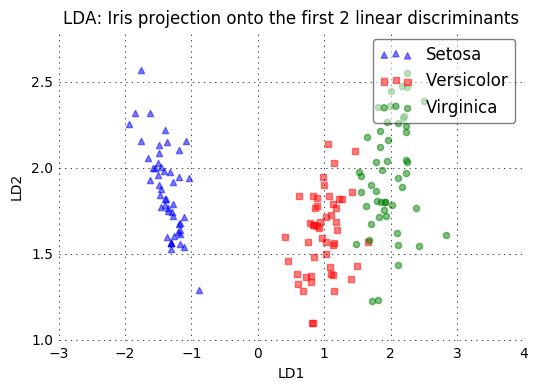

In [17]:
from matplotlib import pyplot as plt

def plot_step_lda():

    ax = plt.subplot(111)
    for label,marker,color in zip(
        range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):

        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)    

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()

The scatter plot above represents our new feature subspace that we constructed via LDA. We can see that the first linear discriminant “LD1” separates the classes quite nicely. However, the second discriminant, “LD2”, does not add much valuable information, which we’ve already concluded when we looked at the ranked eigenvalues is step 4.